In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from frontfixing import nielsen, company
from option import PutAmericanOption

import lcp

In [21]:
def mean_absolute_error(Y_true, Y_pred, axis=0):
    return np.mean(np.abs(Y_true - Y_pred), axis=axis)

def mean_squared_error(Y_true, Y_pred, squared=True, axis=0):
    res =  np.mean(np.power(Y_true - Y_pred, 2), axis=axis)
    if not squared:
        return np.sqrt(res)
    return res

In [22]:
r = 0.08
sigma = 0.2
T = 3
K = 100

put = PutAmericanOption(K, T)
S_test = [90,100,110,120]
V_test = [11.6974, 6.9320, 4.1550, 2.5102]

# Front fixing method

## Inverse transformation

### Explicit


#### Space

In [34]:
dx = [1/8, 1/16, 1/32, 1/64, 1/128]
dt = 1e-6

result = np.empty((len(dx), len(S_test),))
for i, dx_i in enumerate(dx):
    V, S_bar = nielsen.solve_explicitly(put, r, sigma, x_max=3, dx=dx_i, dt=dt)
    V_pred = V(S_test)
    print(mean_squared_error(V_test, V_pred, squared=False, axis=0))
    result[i] = V_pred

0.3344673021505078
0.06942687402110345
0.018082072139738236
0.004340981028613494
0.0009758980245833586


      0.125000   0.062500   0.031250   0.015625   0.007812
90   11.102891  11.585003  11.666996  11.690004  11.695703
100   6.693394   6.863127   6.915119   6.928041   6.931177
110   3.983953   4.116267   4.146001   4.152923   4.154515
120   2.421640   2.490109   2.506015   2.509375   2.510070
[2.08412393 4.60732641]


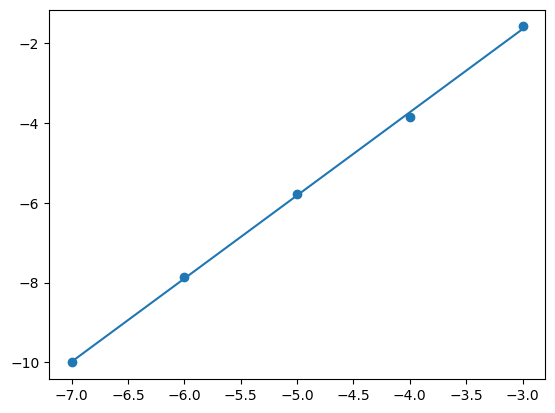

In [38]:
log_dx = np.log2(dx)
log_dx_axis = np.linspace(np.min(log_dx), np.max(log_dx))

result_df = pd.DataFrame(result, index=dx, columns=S_test)
print(result_df.transpose())
error_df = np.sqrt(mean_squared_error(V_test, result_df, axis=1))
log_error_df = np.log2(error_df)

p = np.polyfit(log_dx, log_error_df, deg=1)
f = np.poly1d(p)
print(p)
plt.scatter(log_dx, log_error_df)
plt.plot(log_dx_axis, f(log_dx_axis))
plt.show()

#### Time

In [32]:
dx = 1/8
dt = 0.5*np.power([1e-3], 2)

result = np.empty((len(dt), len(S_test),))
for i, dt_i in enumerate(dt):
    V, S_bar = nielsen.solve_explicitly(put, r, sigma, x_max=3, dx=dx, dt=dt_i)
    V_pred = V(S_test)
    print(mean_squared_error(V_test, V_pred, squared=False, axis=0))
    result[i] = V_pred

0.33446708238405803


In [ ]:
log_dt = np.log2(dt)
log_dt_axis = np.linspace(np.min(log_dt), np.max(log_dt))

result_df = pd.DataFrame(result, index=dt, columns=S_test)
error_df = np.sqrt(mean_squared_error(V_test, result_df, axis=1))
log_error_df = np.log2(error_df)

p = np.polyfit(log_dt, log_error_df, deg=2)
f = np.poly1d(p)
print(p)

plt.scatter(log_dt, log_error_df)
plt.plot(log_dt_axis, f(log_dt_axis))
plt.show()

#### Both

In [ ]:
dx = [1/8, 1/16, 1/32, 1/64, 1/128]
dt = 0.5*np.power([1/8, 1/16, 1/32, 1/64, 1/128], 2)

result = np.empty((len(dx), len(S_test),))
for i, dx_i in enumerate(dx):
    V, S_bar = nielsen.solve_explicitly(put, r, sigma, 2, dx_i, dt[i])
    V_pred = V(S_test)
    print(mean_squared_error(V_test, V_pred, squared=False, axis=0))
    result[i] = V_pred

In [ ]:
log_dt = np.log2(dt)
log_dx = np.log2(dx)
log_dt_axis = np.linspace(np.min(log_dt), np.max(log_dt))
log_dx_axis = np.linspace(np.min(log_dx), np.max(log_dx))

result_df = pd.DataFrame(result, index=dt, columns=S_test)
error_df = np.sqrt(mean_squared_error(V_test, result_df, axis=1))
log_error_df = np.log2(error_df*np.power(dt,0.5))

p = np.polyfit(log_dt, log_error_df, deg=1)
f = np.poly1d(p)
print(p)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(log_dt, log_error_df)
plt.plot(log_dt_axis, f(log_dt_axis))

p = np.polyfit(log_dx, log_error_df, deg=1)
f = np.poly1d(p)
print(p)

plt.subplot(122)
plt.scatter(log_dx, log_error_df)
plt.plot(log_dx_axis, f(log_dx_axis))
plt.show()

### Implicit

#### Space

In [ ]:
dx = [1/16, 1/32, 1/64, 1/128, 1/256]
dt = 1/1024

result = np.empty((len(dx), len(S_test),))
for i, dx_i in enumerate(dx):
    V, S_bar = nielsen.solve_implicitly(put, r, sigma, 2, dx_i, dt)
    V_pred = V(S_test)
    print(mean_squared_error(V_test, V_pred, squared=False, axis=0))
    result[i] = V_pred

In [ ]:
log_dx = np.log(dx)
log_dx_axis = np.linspace(np.min(log_dx), np.max(log_dx))

result_df = pd.DataFrame(result, index=dx, columns=S_test)
error_df = np.sqrt(mean_squared_error(V_test, result_df, axis=1))
log_error_df = np.log(error_df)
p = np.polyfit(log_dx, log_error_df, deg=1)
f = np.poly1d(p)
print(f)
plt.scatter(log_dx, log_error_df)
plt.plot(log_dx_axis, f(log_dx_axis))
plt.show()

#### Time

In [ ]:
dx = 1/128
dt = [1/8, 1/32, 1/64, 1/128, 1/256]

result = np.empty((len(dt), len(S_test),))
for i, dt_i in enumerate(dt):
    V, S_bar = nielsen.solve_implicitly(put, r, sigma, 2, dx, dt_i)
    V_pred = V(S_test)
    print(mean_squared_error(V_test, V_pred, squared=False, axis=0))
    result[i] = V_pred

In [ ]:
log_dt = np.log2(dt)
log_dt_axis = np.linspace(np.min(log_dt), np.max(log_dt))

result_df = pd.DataFrame(result, index=dt, columns=S_test)
error_df = np.sqrt(mean_squared_error(V_test, result_df, axis=1))
log_error_df = np.log2(error_df)

p = np.polyfit(log_dt, log_error_df, deg=1)
f = np.poly1d(p)
print(f)
plt.scatter(log_dt, log_error_df)
plt.plot(log_dt_axis, f(log_dt_axis))
plt.show()

## Log transformation

### Explicit

#### Space

In [ ]:
dx = [0.04, 0.02, 0.01]
dt = 2e-3

result = np.empty((len(dx), len(S_test),))
for i, dx_i in enumerate(dx):
    V, S_bar = company.solve_explicitly(put, r, sigma, 8, dx_i, dt)
    S = np.linspace(0, 150, num=200)
    V_pred = V(S_test)
    result[i] = V_pred
result

In [ ]:
log_dx = np.log(dx)
result_df = pd.DataFrame(result, index=dx, columns=S_test)
error_df = (result_df - V_test).abs()
log_error_df = np.log(error_df.mean(axis=1))

p = np.polyfit(log_dx, log_error_df, deg=1)
f = np.poly1d(p)
plt.scatter(log_dx, log_error_df)
# plt.plot(f(np.linspace(np.min(log_dx), np.max(log_dx))))
plt.show()

#### Time

# LCP + PSOR

## Explicit

### Space

In [4]:
dx = [1/8, 1/16, 1/32, 1/64]
dt = 1/1024

result = np.empty((len(dx), len(S_test),))
for i, dx_i in enumerate(dx):
    V, S_bar = lcp.solve(put, r, sigma, dx_i, dt, x_min=-3, x_max=3)
    V_pred = V(S_test)
    print(mean_squared_error(V_test, V_pred, squared=False, axis=0))
    result[i] = V_pred

AttributeError: 'GUtil' object has no attribute 'T'

In [ ]:
log_dx = np.log(dx)
log_dx_axis = np.linspace(np.min(log_dx), np.max(log_dx))

result_df = pd.DataFrame(result, index=dx, columns=S_test)
error_df = np.sqrt(mean_squared_error(V_test, result_df, axis=1))
log_error_df = np.log(error_df)
p = np.polyfit(log_dx, log_error_df, deg=1)
f = np.poly1d(p)
print(f)
plt.scatter(log_dx, log_error_df)
plt.plot(log_dx_axis, f(log_dx_axis))
plt.show()

### Time

In [19]:
dx = 1/16
dt = [1/128, 1/256, 1/1024]

result = np.empty((len(dt), len(S_test),))
for i, dt_i in enumerate(dt):
    V, S_bar = lcp.solve(put, r, sigma, dx=dx, dt=dt_i, x_min=-3, x_max=3, wR=1)
    V_pred = V(S_test)
    print(mean_squared_error(V_test, V_pred, squared=False, axis=0))
    result[i] = V_pred

0.050232493861669544
0.05002863786813268
0.04988037703426791


 
0.01252 x - 2.919


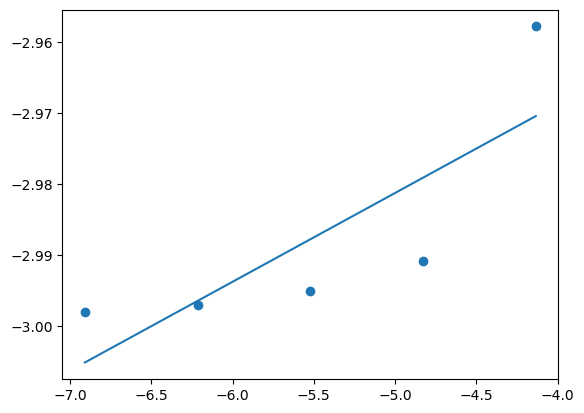

In [16]:
log_dt = np.log(dt)
log_dt_axis = np.linspace(np.min(log_dt), np.max(log_dt))

result_df = pd.DataFrame(result, index=dt, columns=S_test)
error_df = np.sqrt(mean_squared_error(V_test, result_df, axis=1))
log_error_df = np.log(error_df)
p = np.polyfit(log_dt, log_error_df, deg=1)
f = np.poly1d(p)
print(f)
plt.scatter(log_dt, log_error_df)
plt.plot(log_dt_axis, f(log_dt_axis))
plt.show()

## Implicit

### Space

In [ ]:
dx = [1/8, 1/16, 1/32, 1/64]
dt = 1/128

result = np.empty((len(dx), len(S_test),))
for i, dx_i in enumerate(dx):
    V, S_bar = lcp.solve(put, r, sigma, dx=dx_i, dt=dt, x_min=-3, x_max=3, theta=1)
    V_pred = V(S_test)
    print(mean_squared_error(V_test, V_pred, squared=False, axis=0))
    result[i] = V_pred

In [ ]:
log_dx = np.log(dx)
log_dx_axis = np.linspace(np.min(log_dx), np.max(log_dx))

result_df = pd.DataFrame(result, index=dx, columns=S_test)
error_df = np.sqrt(mean_squared_error(V_test, result_df, axis=1))
log_error_df = np.log(error_df)
p = np.polyfit(log_dx, log_error_df, deg=1)
f = np.poly1d(p)
print(f)
plt.scatter(log_dx, log_error_df)
plt.plot(log_dx_axis, f(log_dx_axis))
plt.show()

### Time

In [ ]:
dx = 1/64
dt = [1/2, 1/4, 1/8, 1/16, 1/32]

result = np.empty((len(dt), len(S_test),))
for i, dt_i in enumerate(dt):
    V, S_bar = lcp.solve(put, r, sigma, dx=dx, dt=dt_i, x_min=-3, x_max=3, theta=1)
    V_pred = V(S_test)
    print(mean_squared_error(V_test, V_pred, squared=False, axis=0))
    result[i] = V_pred

In [ ]:
log_dt = np.log(dt)
log_dt_axis = np.linspace(np.min(log_dt), np.max(log_dt))

result_df = pd.DataFrame(result, index=dt, columns=S_test)
error_df = np.sqrt(mean_squared_error(V_test, result_df, axis=1))
log_error_df = np.log(error_df)
p = np.polyfit(log_dt, log_error_df, deg=1)
f = np.poly1d(p)
print(f)
plt.scatter(log_dt, log_error_df)
plt.plot(log_dt_axis, f(log_dt_axis))
plt.show()

## Crank nicholson

### Space

In [ ]:
dx = [1/8, 1/16, 1/32, 1/64, 1/128]
dt = 1/1024

result = np.empty((len(dx), len(S_test),))
for i, dx_i in enumerate(dx):
    V, S_bar = lcp.solve(put, r, sigma, dx=dx_i, dt=dt, x_min=-3, x_max=3, theta=0.5)
    V_pred = V(S_test)
    print(mean_squared_error(V_test, V_pred, squared=False, axis=0))
    result[i] = V_pred

In [ ]:
log_dx = np.log(dx)
log_dx_axis = np.linspace(np.min(log_dx), np.max(log_dx))

result_df = pd.DataFrame(result, index=dx, columns=S_test)
error_df = np.sqrt(mean_squared_error(V_test, result_df, axis=1))
log_error_df = np.log(error_df)
p = np.polyfit(log_dx, log_error_df, deg=1)
f = np.poly1d(p)
print(f)
plt.scatter(log_dx, log_error_df)
plt.plot(log_dx_axis, f(log_dx_axis))
plt.show()

### Time

In [ ]:
dx = 1/64
dt = [1/2, 1/4, 1/8, 1/16]

result = np.empty((len(dt), len(S_test),))
for i, dt_i in enumerate(dt):
    V, S_bar = lcp.solve(put, r, sigma, dx=dx, dt=dt_i, x_min=-3, x_max=3, theta=0.5)
    V_pred = V(S_test)
    print(mean_squared_error(V_test, V_pred, squared=False, axis=0))
    result[i] = V_pred

In [ ]:
log_dt = np.log(dt)
log_dt_axis = np.linspace(np.min(log_dt), np.max(log_dt))

result_df = pd.DataFrame(result, index=dt, columns=S_test)
error_df = np.sqrt(mean_squared_error(V_test, result_df, axis=1))
log_error_df = np.log(error_df)
p = np.polyfit(log_dt, log_error_df, deg=1)
f = np.poly1d(p)
print(f)
plt.scatter(log_dt, log_error_df)
plt.plot(log_dt_axis, f(log_dt_axis))
plt.show()